### Score: 29

Q1.[7]

Q2.[11+11]

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from netCDF4 import num2date
import seaborn as sns
import cftime
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

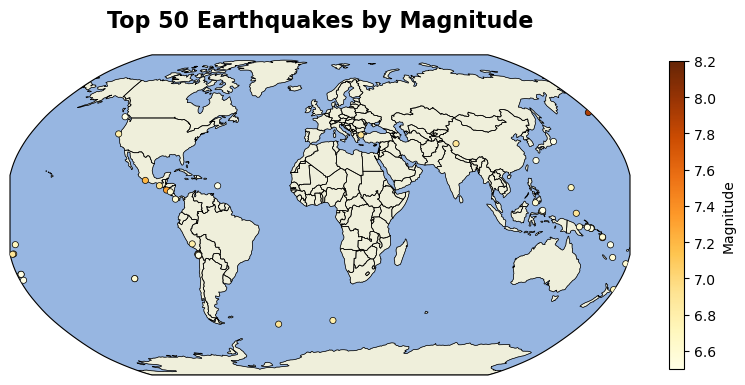

In [5]:
# 1. Global Earthquakes
# 读取文件，检查数据
Usgs_Eqs = pd.read_csv(r"C:\Users\zjm\Desktop\ESE_5023\usgs_earthquakes.csv")
#Usgs_Eqs.head()
#Usgs_Eqs.info()

Usgs_Eqs_ordered = Usgs_Eqs.sort_values('mag', ascending=False)
Usgs_Eqs_top50 = Usgs_Eqs_ordered.head(50)
#print(Usgs_Eqs_top50)

# Create and define the size of a figure object 
plt.figure(figsize=(10,10), dpi=100)

# Create an axes with an basic PlateCarree projection style
proj = ccrs.Robinson()
ax = plt.axes(projection=proj)

# 添加陆地和海洋
ax.add_feature(cfeature.NaturalEarthFeature(category='physical',
                                           name='land',
                                           scale='110m',
                                           facecolor=cfeature.COLORS['land'],
                                           edgecolor='black',
                                           linewidth=0.1,
                                           zorder=0))
ax.add_feature(cfeature.NaturalEarthFeature(category='physical',
                                           name='ocean',
                                           scale='110m',
                                           facecolor=cfeature.COLORS['water'],
                                           edgecolor='black',
                                           linewidth=0.1,
                                           zorder=1))

# 添加国界线
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='110m',
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.5,
                                           zorder=2))

# 定义点的经纬度坐标
lons = Usgs_Eqs_top50['longitude']  
lats = Usgs_Eqs_top50['latitude']  
mag = Usgs_Eqs_top50['mag']

# 在地图上绘制点
sc = ax.scatter(lons, lats, 
               c=mag, cmap='YlOrBr', 
               s=20, transform=ccrs.PlateCarree(), 
               edgecolor='k', linewidths=0.5, 
               zorder=3)

ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# 添加颜色条，使用从黄到红的色卡
cbar = plt.colorbar(sc, ax=ax, shrink=0.4, orientation='vertical', pad=0.05)
cbar.set_label('Magnitude')

# 设置标题
ax.set_title('Top 50 Earthquakes by Magnitude', fontsize=16, fontweight='bold', pad=20)
# NOTE: 底图、投影中心和颜色映射应与例图一致 -3
plt.show()

接下来这段代码来自于网页https://zhajiman.github.io/post/cartopy_lambert/
用于给非平面投影的地图添加坐标轴上的刻度

In [844]:
def find_x_intersections(ax, xticks):
    '''找出xticks对应的经线与下x轴的交点在data坐标下的位置和对应的ticklabel.'''
    # 获取地图的矩形边界和最大的经纬度范围.
    x0, x1, y0, y1 = ax.get_extent()
    lon0, lon1, lat0, lat1 = ax.get_extent(ccrs.PlateCarree())
    xaxis = sgeom.LineString([(x0, y0), (x1, y0)])
    # 仅选取能落入地图范围内的ticks.
    lon_ticks = [tick for tick in xticks if tick >= lon0 and tick <= lon1]

    # 每条经线有nstep个点.
    nstep = 50
    xlocs = []
    xticklabels = []
    for tick in lon_ticks:
        lon_line = sgeom.LineString(
            ax.projection.transform_points(
                ccrs.Geodetic(),
                np.full(nstep, tick),
                np.linspace(lat0, lat1, nstep)
            )[:, :2]
        )
        # 如果经线与x轴有交点,获取其位置.
        if xaxis.intersects(lon_line):
            point = xaxis.intersection(lon_line)
            xlocs.append(point.x)
            xticklabels.append(tick)
        else:
            continue

    # 用formatter添上度数和东西标识.
    formatter = LongitudeFormatter()
    xticklabels = [formatter(label) for label in xticklabels]

    return xlocs, xticklabels

def find_y_intersections(ax, yticks):
    '''找出yticks对应的纬线与左y轴的交点在data坐标下的位置和对应的ticklabel.'''
    x0, x1, y0, y1 = ax.get_extent()
    lon0, lon1, lat0, lat1 = ax.get_extent(ccrs.PlateCarree())
    yaxis = sgeom.LineString([(x0, y0), (x0, y1)])
    lat_ticks = [tick for tick in yticks if tick >= lat0 and tick <= lat1]

    nstep = 50
    ylocs = []
    yticklabels = []
    for tick in lat_ticks:
        # 注意这里与find_x_intersections的不同.
        lat_line = sgeom.LineString(
            ax.projection.transform_points(
                ccrs.Geodetic(),
                np.linspace(lon0, lon1, nstep),
                np.full(nstep, tick)
            )[:, :2]
        )
        if yaxis.intersects(lat_line):
            point = yaxis.intersection(lat_line)
            ylocs.append(point.y)
            yticklabels.append(tick)
        else:
            continue

    formatter = LatitudeFormatter()
    yticklabels = [formatter(label) for label in yticklabels]

    return ylocs, yticklabels

def set_lambert_ticks(ax, xticks, yticks):
    '''
    给一个LambertConformal投影的GeoAxes在下x轴与左y轴上添加ticks.

    要求地图边界是矩形的,即ax需要提前被set_extent方法截取成矩形.
    否则可能会出现错误.

    Parameters
    ----------
    ax : GeoAxes
        投影为LambertConformal的Axes.

    xticks : list of floats
        x轴上tick的位置.

    yticks : list of floats
        y轴上tick的位置.

    Returns
    -------
    None
    '''
    # 设置x轴.
    xlocs, xticklabels = find_x_intersections(ax, xticks)
    ax.set_xticks(xlocs)
    ax.set_xticklabels(xticklabels)
    # 设置y轴.
    ylocs, yticklabels = find_y_intersections(ax, yticks)
    ax.set_yticks(ylocs)
    ax.set_yticklabels(yticklabels)


接下来使用的数据来自以下网页，是一个全球燃料开发（GFEI）甲烷排放清单，分辨率为0.1 x 0.1度
https://disc.gsfc.nasa.gov/datasets/GFEI_CH4_1/summary

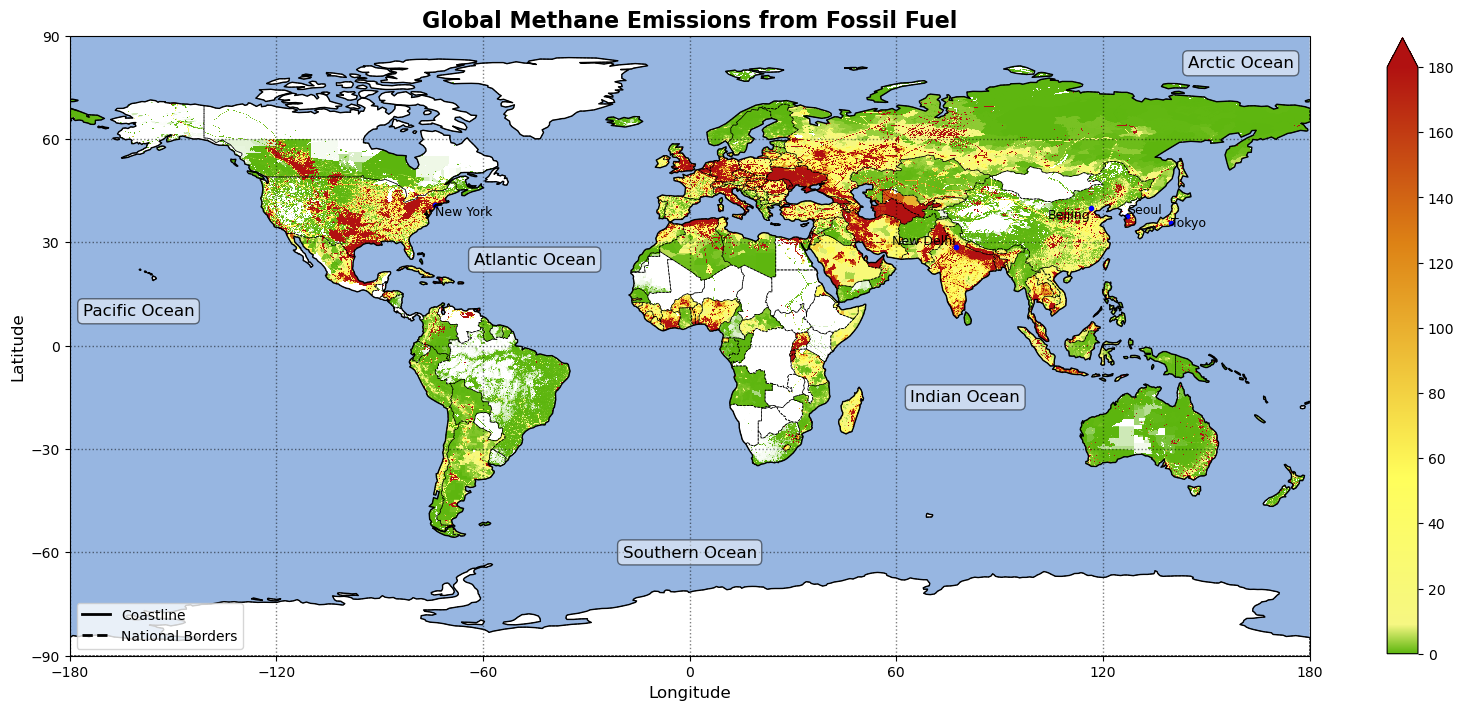

In [850]:
# 2. Explore a netCDF dataset
# 2.1 Global Map
# 读取文件，检查文件信息
CH4_Fuel_Origin = xr.open_dataset("Global_Fuel_Exploitation_Inventory_GFEI_CH4_v1_2016.nc", engine="netcdf4")
#print(CH4_Fuel_Origin)

# 创建图形，设置大小和分辨率
plt.figure(figsize=(20,10), dpi=100)

# 创建带有投影的坐标轴
ax = plt.axes(projection=ccrs.PlateCarree())

# 自定义颜色条
colors = [(0, 'White'), (0.0001, '#5CB50E'), (0.05, '#F6F782'), (0.30, '#FFFE5B'), (0.70, '#DD8215'), (1, '#B11111')]
cmap_name = 'custom_cmap'
n_bins = 500000
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# 添加海洋
ax.add_feature(cfeature.OCEAN, zorder=2)

# 将排放量放大并绘制到地图上
data_bigger = CH4_Fuel_Origin['total_fuel_exploitation_emis_ch4'] * 1000
data_bigger.plot(ax=ax, transform=ccrs.PlateCarree(),
        cmap=cmap, vmin=0, vmax=180, cbar_kwargs={'shrink': 0.8, 'label': None})

# 添加国家边界线和海岸线
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='110m',
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.5, linestyle='--',
                                           zorder=3))
coastline = ax.coastlines(resolution='110m', color='black', linewidth=1, linestyle='-',
                                           zorder=3)
# 添加图例
legend_elements = [
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Coastline'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='National Borders')
]
ax.legend(handles=legend_elements, loc='lower left')

# 定义城市及其经纬度
cities = {
    'Tokyo': (35.6895, 139.6917,'left','center'),
    'Beijing': (39.9042, 116.4074,'right','top'),
    'New York': (40.7128, -74.0060,'left','top'),
    'Seoul': (37.5665, 126.9780,'left','bottom'),
    'New Delhi': (28.6139, 77.2090, 'right', 'bottom')
}

# 标出城市并添加注释
for city, (lat, lon, ha, va) in cities.items():
    ax.plot(lon, lat, 'o', color='blue', markersize=3)  # 标记城市位置
    ax.text(lon, lat, f'{city}', transform=ccrs.PlateCarree(),
            fontsize=9, ha=ha, va=va)

# 定义五大洋的中心位置和名称
oceans = {
    'Pacific': {'lon': -160, 'lat': 10, 'name': 'Pacific Ocean'},
    'Atlantic': {'lon': -45, 'lat': 25, 'name': 'Atlantic Ocean'},
    'Indian': {'lon': 80, 'lat': -15, 'name': 'Indian Ocean'},
    'Arctic': {'lon': 160, 'lat': 82, 'name': 'Arctic Ocean'},
    'Southern Ocean': {'lon': 0, 'lat': -60, 'name': 'Southern Ocean'}
}

# 在五大洋中心添加文本框
for ocean in oceans.values():
    ax.text(ocean['lon'], ocean['lat'], ocean['name'], transform=ccrs.PlateCarree(),
            fontsize=12, ha='center', va='center',
            bbox=dict(boxstyle="round", facecolor='white', edgecolor='black', alpha=0.5))
    
# 设置X轴和Y轴的标签及刻度
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

# 添加经纬度网格线
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle=':')

# 设置XY轴标题
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# 设置标题
plt.title('Global Methane Emissions from Fossil Fuel', fontsize=16, weight='bold')

# 显示图形
plt.show()

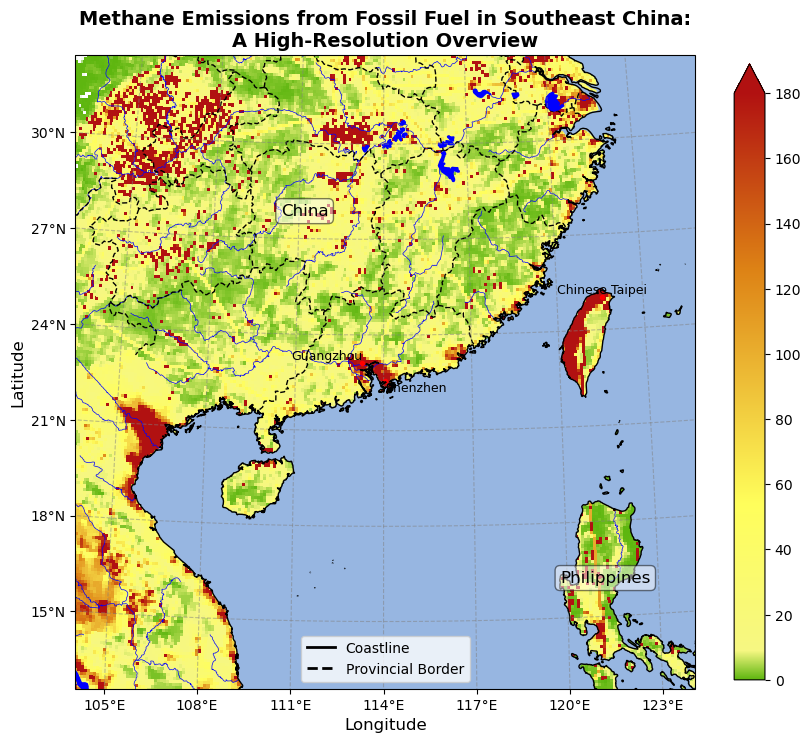

In [851]:
#2.2 Regional Map
# 获取高精度河流
rivers_10m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m')

# 创建图形，设置大小和分辨率
plt.figure(figsize=(10,10), dpi=100)

# 设置区域中心点，创建带有投影的坐标轴
central_lon, central_lat = 114.06, 22.54 # Shenzhen
proj = ccrs.Orthographic(central_lon, central_lat) 
ax = plt.axes(projection=proj)

# 划定范围
extent = [central_lon-10, central_lon+10, central_lat-10, central_lat+10]
ax.set_extent(extent)

# 添加湖泊、河流
ax.add_feature(cfeature.LAKES, edgecolor='blue', facecolor='blue', zorder=2)
ax.add_feature(rivers_10m, facecolor='None', edgecolor='blue', linewidth=0.5)

# 添加海洋和海岸线
ax.add_feature(cfeature.OCEAN, zorder=2)
coastline = ax.coastlines(resolution='10m', color='black', linewidth=1, linestyle='-',
                                           zorder=3)
# 添加经纬度网格线
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle='--', color='gray', alpha=0.5)

# 设置刻度
xticks = np.arange(102, 126, 3)
yticks = np.arange(15, 56, 3)
set_lambert_ticks(ax, xticks, yticks)

# 自定义颜色条
colors = [(0, 'White'), (0.0001, '#5CB50E'), (0.05, '#F6F782'), (0.30, '#FFFE5B'), (0.70, '#DD8215'), (1, '#B11111')]
cmap_name = 'custom_cmap'
n_bins = 500000
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# 将排放量放大并绘制地图
data_bigger = CH4_Fuel_Origin['total_fuel_exploitation_emis_ch4'] * 1000
data_bigger.plot(ax=ax, transform=ccrs.PlateCarree(),
        cmap=cmap, vmin=0, vmax=180, cbar_kwargs={'shrink': 0.8, 'label': None})

#添加省界线
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                          name='admin_1_states_provinces_lines',
                                          scale='50m',
                                          facecolor='none',
                                          edgecolor='black', 
                                           linestyle='--'))

# 定义广州、深圳和中国台北的经纬度
cities = {
    'Guangzhou': (23.1291, 113.2644,'right','bottom'),
    'Shenzhen': (22.5429, 114.0598,'left','top'),
    'Chinese Taipei': (25.0338, 121.5639,'center','bottom')
}

# 在地图上标出城市并添加文本
for city, (lat, lon, ha, va) in cities.items():
    ax.plot(lon, lat, 'o', color='red', markersize=3, transform=ccrs.PlateCarree())
    ax.text(lon, lat, city, transform=ccrs.PlateCarree(),
            fontsize=9, ha=ha, va=va)

# 定义菲律宾和中国的大致中心点经纬度
Philippines_center = (16.2048, 121.2529)  # 日本中心点，东京附近
china_center = (27.8617, 111.1954)  # 中国中心点，兰州附近

# 在地图上标出国家并添加文本框
ax.text(Philippines_center[1], Philippines_center[0], 'Philippines', transform=ccrs.PlateCarree(),
        fontsize=12, ha='center', va='center',
        bbox=dict(boxstyle="round", facecolor='white', edgecolor='black', alpha=0.5))
ax.text(china_center[1], china_center[0], 'China', transform=ccrs.PlateCarree(),
        fontsize=12, ha='center', va='center',
        bbox=dict(boxstyle="round", facecolor='white', edgecolor='black', alpha=0.5))

# 添加图例
legend_elements = [
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Coastline'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Provincial Border')
]
ax.legend(handles=legend_elements, loc='lower center')

# 设置XY轴标题
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# 设置图片标题
plt.title('Methane Emissions from Fossil Fuel in Southeast China:\nA High-Resolution Overview', fontsize=14, weight='bold')

# 显示图形
plt.show()